# Imports and Libraries

In [48]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import time

#Loading the Data


In [49]:
def load_data_cifar10(batch_size, resize=None):

    # Transformations applied to the training dataset
    train_trans = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizes a tensor image with mean and standard deviation
    ]

    # Transformations applied to the testing dataset
    test_trans = [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizes a tensor image with mean and standard deviation
    ]

    # Transformations are chained together through 'Compose' so they are applied sequentially
    train_trans = transforms.Compose(train_trans)
    test_trans = transforms.Compose(test_trans)

    mnist_train = datasets.CIFAR10(
        root="../data", train=True, transform=train_trans, download=True) # Loads the CIFAR-10 training dataset from the specified path, applies the transformations, and downloads the data if not present
    mnist_test = datasets.CIFAR10(
        root="../data", train=False, transform=test_trans, download=True) # # Loads the CIFAR-10 test dataset from the specified path, applies the transformations, and downloads the data if not present

    # Returns a tuple of DataLoader objects for the training and test datasets

    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2, pin_memory=True), # For training data, enables shuffling and uses pinned memory for faster data transfer to CUDA devices
             torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)) # For test data, does not shuffle and uses pinned memory

In [50]:
batch_size = 64 # Defines the batch size
train_iter, test_iter = load_data_cifar10(batch_size) # Loads the fashion CIFAR dataset. `train_iter` and `test_iter` are `DataLoader` objects.

Files already downloaded and verified
Files already downloaded and verified


In [51]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # Prints the size/shape of the input features tensor `X`
print(y.size()) # Prints the size/shape of the labels tensor `y`

torch.Size([64, 3, 32, 32])
torch.Size([64])


# The Architecture
## The Intermediate Sequential Block Class

In [52]:
class SequentialBlock(nn.Module): #the intermediate sequential blocks inheritted from nn module
    def __init__(self, chan_inputs, no_conv_layers, chan_outputs): #input channels, no. of convulational layers in block, output channels
        super(SequentialBlock, self).__init__()
        # kernel sizes and padding values for convolutional layers
        K=[3,5,7,9]
        P=[1,2,3,4]
        self.no_conv_layers = no_conv_layers # Store the number of convolutional layers

        # ModuleList of convolutional layers, each wrapped in a Sequential container
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(chan_inputs, chan_outputs, kernel_size=K[i], padding=P[i]),
                # Batch Normalization and ReLU activation for each layer. The first layer's input channels
                nn.BatchNorm2d(chan_outputs),
                nn.ReLU(inplace=True)
            ) for i in range(no_conv_layers)
        ])
        # A fully connected linear layer that will compute weights 'a' based on the flattened output of the adaptive average pooling layer. The input features match 'chan_inputs',
        self.fc = nn.Linear(chan_inputs, no_conv_layers)  # Fully connected layer to compute weights 'a'
        self.dropout = nn.Dropout(0.5) # Dropout layer for regularization, dropping out 50% of the activations
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3]) #Compute 'm'
        a = torch.sigmoid(self.fc(m))  # Compute the weights 'a' with sigmoid function
        # Process the same input 'x' through each convolutional layer independently
        conv_outputs = [conv_layer(x) for conv_layer in self.conv_layers]
        # Stack and weight the convolutional outputs
        stacked_outputs = torch.stack(conv_outputs, dim=1)
        a_expanded = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Expand 'a'
        x = (stacked_outputs * a_expanded).sum(dim=1)  # Sum over the correct dimension
        x = self.dropout(x)
        return x

##The Output Block Class

In [53]:
class OutputBlock(nn.Module):
    # No change from your original OutputBlock
    def __init__(self, chan_inputs, num_classes):
        super(OutputBlock, self).__init__()
        # Initializes an adaptive average pooling layer that reduces the spatial dimensions of the input tensor to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
         # Initializes a fully connected linear layer that transforms the pooled output into class scores where The number of input features to this layer is expected to match the number of output channels from the previous layer
        # `num_classes` specifies the  number of classes in a classification task
        self.fc = nn.Linear(chan_inputs, num_classes)

    def forward(self, x):
        # Applies global average pooling to the input tensor `x`
        x = self.global_avg_pool(x)
        # Flattens the pooled output to remove the 1x1 spatial dimensions, preparing it for input into the linear layer
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # Returns the final output
        return x

## Model class specifying the chosen number of blocks and layers

In [54]:
class CifarModel(nn.Module):
    # No change from your original CifarModel, assuming it aligns with your desired architecture
    def __init__(self, num_classes=10):
        super(CifarModel, self).__init__()
        # Channel inputs indicate that the input images have 3 channels (RGB). Number of convulational layers. Channel outputs means each convolutional layer in this block will output specified number of feature maps
        self.block1 = SequentialBlock(chan_inputs=3, no_conv_layers=4, chan_outputs=64)
        self.block2 = SequentialBlock(chan_inputs=64, no_conv_layers=4, chan_outputs=128)
        self.block3 = SequentialBlock(chan_inputs=128, no_conv_layers=4, chan_outputs=256)
        self.output_block = OutputBlock(chan_inputs=256, num_classes=num_classes)

    def forward(self, x):
        x = self.block1(x) # Processes the input through the first sequential block, updating 'x' with the output
        x = self.block2(x)  # The output of the first block is then passed through the second sequential block
        x = self.block3(x) # The output of the second block is passed through the third sequential block
        x = self.output_block(x)
        # The final output 'x' now contains the predicted scores for each class for classification
        return x

#Setting up training components, loss function, optimiser and evaluating accuracy function

In [55]:
# Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CifarModel(num_classes=10).to(device)
#Loss function for training
loss_fn = nn.CrossEntropyLoss()
#Optimiser to update model paramters
optimizer = optim.Adam(model.parameters(), lr=0.01)
#Training batch size
batch_size = 100
train_loader, test_loader = load_data_cifar10(batch_size)

# Evaluation function
def evaluate_accuracy(data_iter, net, device=torch.device('cpu')):
    net.eval()
    #initialise at 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            logits = net(X) # Generates output logits (raw prediction scores) from the model.
            _, predicted = torch.max(logits.data, 1) # Determines the predicted class by selecting the class with the highest score for each instance
            total += y.size(0)  # Accumulates the total number of samples in the batch
            correct += (predicted == y).sum().item() # Increments the correct counter by the number of correctly predicted instances
    return correct / total  # Computes the overall accuracy

Files already downloaded and verified
Files already downloaded and verified


#Training and Plotting accuracy

Epoch 1, Loss: 1.8006, Train acc: 0.3462, Test acc: 0.3403
Epoch 2, Loss: 1.3179, Train acc: 0.5157, Test acc: 0.5014
Epoch 3, Loss: 1.0775, Train acc: 0.6360, Test acc: 0.6208
Epoch 4, Loss: 0.9464, Train acc: 0.6827, Test acc: 0.6605
Epoch 5, Loss: 0.8647, Train acc: 0.6841, Test acc: 0.6737
Epoch 6, Loss: 0.8070, Train acc: 0.7491, Test acc: 0.7210
Epoch 7, Loss: 0.7587, Train acc: 0.7291, Test acc: 0.6992
Epoch 8, Loss: 0.7122, Train acc: 0.7719, Test acc: 0.7443
Epoch 9, Loss: 0.6691, Train acc: 0.7392, Test acc: 0.7065
Epoch 10, Loss: 0.6338, Train acc: 0.7893, Test acc: 0.7652
Epoch 11, Loss: 0.5978, Train acc: 0.7637, Test acc: 0.7330
Epoch 12, Loss: 0.5819, Train acc: 0.8061, Test acc: 0.7796
Epoch 13, Loss: 0.5553, Train acc: 0.8080, Test acc: 0.7724
Epoch 14, Loss: 0.5322, Train acc: 0.8195, Test acc: 0.7857
Epoch 15, Loss: 0.5171, Train acc: 0.8200, Test acc: 0.7775
Epoch 16, Loss: 0.5000, Train acc: 0.8402, Test acc: 0.7888
Epoch 17, Loss: 0.4810, Train acc: 0.8504, Test a

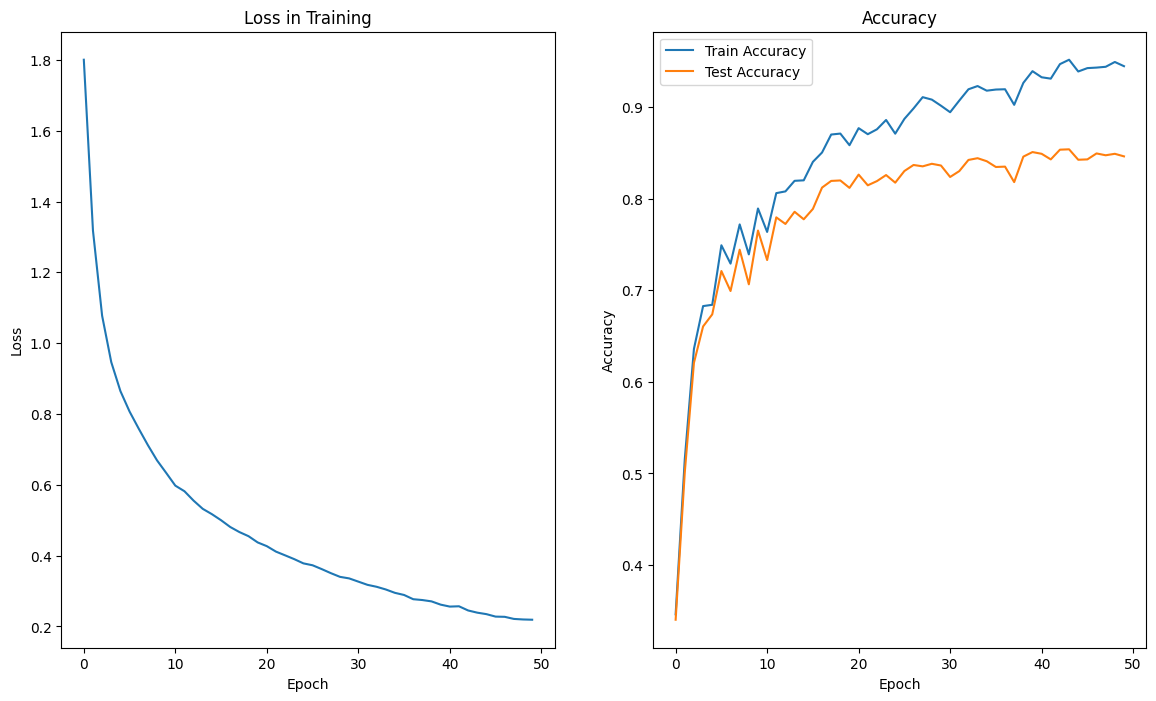

In [56]:
# Training loop
losses = []
train_accs = []
test_accs = []
num_epochs = 50

# Main training loop iterating over each epoch.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculates the average loss over all batches and stores it
    losses.append(running_loss / len(train_loader))
    # models training performance
    train_acc = evaluate_accuracy(train_loader, model, device)
    # models testing performance
    test_acc = evaluate_accuracy(test_loader, model, device)

    # Records the accuracy for this epoch
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

# Plotting the loss in training, and accuracies for test and training
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Training')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()